In [1]:
import pandas as pd
import numpy as np

In [2]:
#import the backtesting dataset
pfe = pd.read_csv('I:\python_file\save\M4 (1)\LSTM Multi\LSTM_Multistep_label.csv', index_col=0)
pfe = pfe.set_index(pd.DatetimeIndex(pfe.index))
pfe = pfe[(pfe.index > "2021-06-01")]

In [3]:
pfe

,Adj Close,Predict_close
2021-06-02,38.107330,0.001443
2021-06-03,38.284161,0.003499
2021-06-04,38.460995,-0.000242
2021-06-07,38.303810,-0.002280
2021-06-08,38.166271,0.002741
...,...,...
2021-12-08,51.400002,0.000084
2021-12-09,52.080002,-0.000873
2021-12-10,52.779999,0.004637
2021-12-13,55.200001,0.009157


In [4]:
#import the dataset into a new dataframe 
signals = pd.DataFrame(index=pfe.index)
signals['signal'] = 0.0
#signals['return'] = pfe['Daily Return']
signals['predict'] = pfe['Predict_close']
signals['close'] = pfe['Adj Close']
signals['date'] = signals.index
signals = signals.reset_index()

In [5]:
#Create signals when to buy the stock dependet on the predctions 

# how big should the prediction be before buy position 
span = 0.001

#Create signal if the stock is going up by more then the span
predict_list = [0]
for x in signals['predict']:     
    if x > span:
        list = 1
        predict_list.append(list)
    elif predict_list[-1]==1:
        if x<-0.001:
            list1 = 1
            predict_list.append(list1)
        #else:
        #    list2 = -1
        #    predict_list.append(list2)
        else: 
            list3 = 0
            predict_list.append(list3)
    else: 
        list3 = 0
        predict_list.append(list3)

del predict_list[0]
#del predict_list[-1]
#predict_list.append(-1)
signals['signal'] = predict_list

In [6]:
signals

,index,signal,predict,close,date
0,2021-06-02,1,0.001443,38.107330,2021-06-02
1,2021-06-03,1,0.003499,38.284161,2021-06-03
2,2021-06-04,0,-0.000242,38.460995,2021-06-04
3,2021-06-07,0,-0.002280,38.303810,2021-06-07
4,2021-06-08,1,0.002741,38.166271,2021-06-08
...,...,...,...,...,...
129,2021-12-08,0,0.000084,51.400002,2021-12-08
130,2021-12-09,0,-0.000873,52.080002,2021-12-09
131,2021-12-10,1,0.004637,52.779999,2021-12-10
132,2021-12-13,1,0.009157,55.200001,2021-12-13


In [8]:
# create a new list depending on the signal 
#buy and keep aslong as the signal says 1 and change to sell -1 when the buy signal stops 
signals['positions'] = signals['signal'].diff()

#import the dates as index again
signals = signals.set_index('date',drop=True)
#del signals['index']

In [9]:
signals.head(3)

,index,signal,predict,close,positions
date,,,,,
2021-06-02,2021-06-02,1,0.001443,38.107330,NaN
2021-06-03,2021-06-03,1,0.003499,38.284161,0.0
2021-06-04,2021-06-04,0,-0.000242,38.460995,-1.0


In [10]:
print(signals.signal.value_counts())
print(signals.positions.value_counts())

1    98
0    36
Name: signal, dtype: int64
 0.0    104
-1.0     15
 1.0     14
Name: positions, dtype: int64


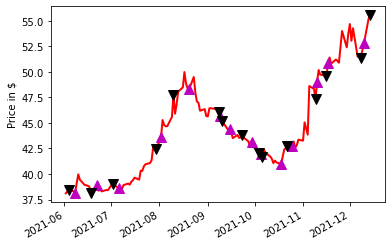

In [11]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
pfe['Adj Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
#signals[['short_mavg_return', 'short_mavg_predict']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.close[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.close[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [12]:
# Set the initial capital
initial_capital= float(1000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['PFE'] = 10*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(pfe['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(pfe['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(pfe['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.tail())

                   PFE    holdings         cash        total   returns
date                                                                  
2021-12-08    0.000000    0.000000  1494.315758  1494.315758 -0.002137
2021-12-09    0.000000    0.000000  1494.315758  1494.315758  0.000000
2021-12-10  527.799988  527.799988   966.515770  1494.315758  0.000000
2021-12-13  552.000008  552.000008   966.515770  1518.515778  0.016195
2021-12-14    0.000000    0.000000  1521.915779  1521.915779  0.002239


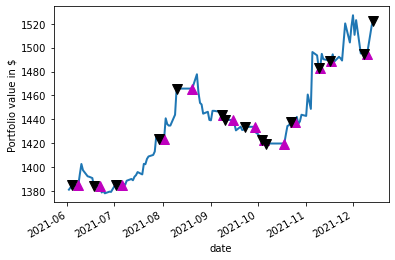

In [13]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=520f7743-fdb5-41d4-ba65-deb67c6338e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>